In [1]:
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

import MDAnalysis as mda
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import pyemma
from pyemma.coordinates import source
from pyemma.util.contexts import settings

In [2]:
import numpy as np

In [3]:
arr1 = [pyemma.coordinates.load(f'../features_v1/contacts_v1_{i:03d}.npy') for i in range(9)]

In [4]:
arr2 = [pyemma.coordinates.load(f'../features_v1/coord_v1_{i:03d}.npy') for i in range(9)]

In [5]:
arr3 = [pyemma.coordinates.load(f'../features_v1/t_new_{i:03d}.npy') for i in range(9)]

In [6]:
arr4 = [pyemma.coordinates.load(f'../features_v1/ca_com_v1_{i:03d}.npy') for i in range(9)]

In [7]:
arr5 = [pyemma.coordinates.load(f'../features_v1/torsions_v1_{i:03d}.npy') for i in range(9)]

In [8]:
arr6 = [pyemma.coordinates.load(f'../features_v1/ca_v1_{i:03d}.npy') for i in range(9)]

In [27]:
combo_all = [np.concatenate([a1, a2, a3, a4, a5, a6], axis=1) for a1, a2, a3, a4, a5, a6 in zip(arr3, arr4, arr2, arr1, arr5, arr6)]


In [30]:
combo_ext = [np.concatenate([a1, a2, a3, a4], axis=1) for a1, a2, a3, a4 in zip(arr3, arr4, arr2, arr1)]


In [21]:
arr3

[array([[ 0.48988724,  0.6028862 ,  0.670887  , ...,  1.5398865 ,
          1.6718864 ,  1.0888863 ],
        [ 0.25152206,  0.3755226 ,  0.48352242, ...,  0.94052315,
          1.0055218 ,  0.7805233 ],
        [ 0.3697033 ,  0.50170326,  0.62070465, ...,  1.1777039 ,
          1.3077049 ,  0.7977047 ],
        ...,
        [ 0.01072693, -0.00827217, -0.12527275, ...,  0.19272804,
          0.25172806,  0.2637272 ],
        [ 0.05498886,  0.06398964, -0.06001091, ...,  0.3059883 ,
          0.35898972,  0.4059887 ],
        [ 0.1131134 ,  0.08611488, -0.0308857 , ...,  0.3951149 ,
          0.44511414,  0.39811325]], dtype=float32),
 array([[0.2737732 , 0.4047737 , 0.5637741 , ..., 1.4207745 , 1.5577736 ,
         0.9987736 ],
        [0.75463676, 0.76763725, 0.64863586, ..., 1.3726368 , 1.5086365 ,
         0.9546375 ],
        [0.41848755, 0.5464878 , 0.7184887 , ..., 1.3344879 , 1.4424877 ,
         1.0034885 ],
        ...,
        [5.754944  , 5.717943  , 5.776943  , ..., 6.55294

Now we have to start loading these into tICA


In [32]:
labels = ['contacts','coordination','heavy dists','ca COM dists','torsions','ca-ca','combo-all','comba-ext']

[5.525439754556248]
[4.812801943923747]
[4.244289832918599]


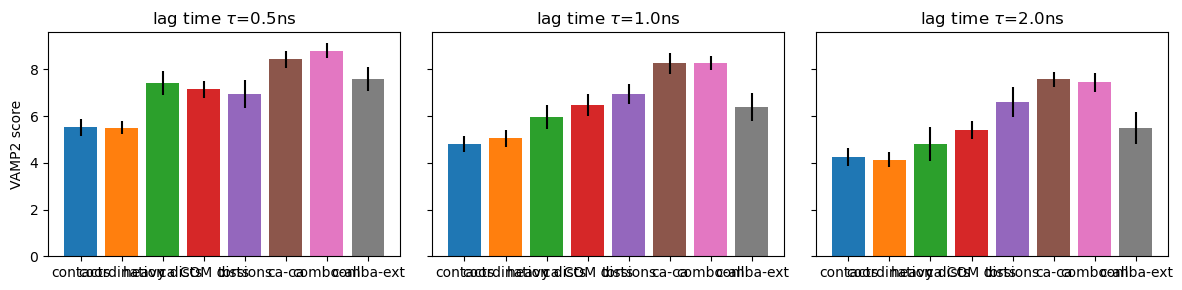

In [33]:
def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores


dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(arr1, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    print(scores)
    positions_scores = score_cv(arr2, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(arr3, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ca_com_scores = score_cv(arr4, lag=lag, dim=dim)
    scores += [ca_com_scores.mean()]
    errors += [ca_com_scores.std()]
    torsion_scores = score_cv(arr5, lag=lag, dim=dim)
    scores += [torsion_scores.mean()]
    errors += [torsion_scores.std()]
    ca_dist_scores = score_cv(arr6, lag=lag, dim=dim)
    scores += [ca_dist_scores.mean()]
    errors += [ca_dist_scores.std()]
    combo_all_scores = score_cv(combo_all, lag=lag, dim=dim)
    scores += [combo_all_scores.mean()]
    errors += [combo_all_scores.std()]
    combo_ext_scores = score_cv(combo_ext, lag=lag, dim=dim)
    scores += [combo_ext_scores.mean()]
    errors += [combo_ext_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C0', 'C1', 'C2','C3','C4','C5','C6','C7'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or len(trajfiles) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:384: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (any(isinstance(item, (list, tuple, _string_types)) for item in inp) or len(inp) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:388: SyntaxWarning: "is" with a literal. Did you mean "=="?
  and (any(isinstance(item, _np.ndarray) for item in inp) or len(inp) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/pyemma/coordinates/api.py:242: SyntaxWarning: "is" with a literal. Did you mean "=="?
  or len(trajfiles) is 0)):
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/m

KeyboardInterrupt: 

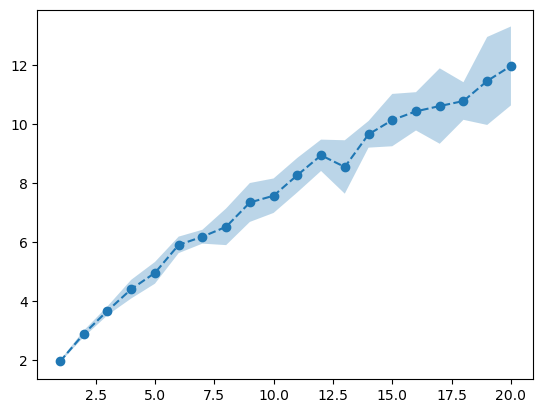

In [35]:
lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(20)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(arr5, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

In [16]:
tica_dev = pyemma.coordinates.tica(arr3, lag=20)
tica_out = tica_dev.get_output()
tica_concatenated = np.concatenate(tica_out)

calculate covariances:   0%|                                                                                  …

getting output of TICA:   0%|                                                                                 …

In [17]:
np.shape(arr3[0])

(10001, 203)

In [18]:
np.shape(tica_concatenated)

(98374, 70)

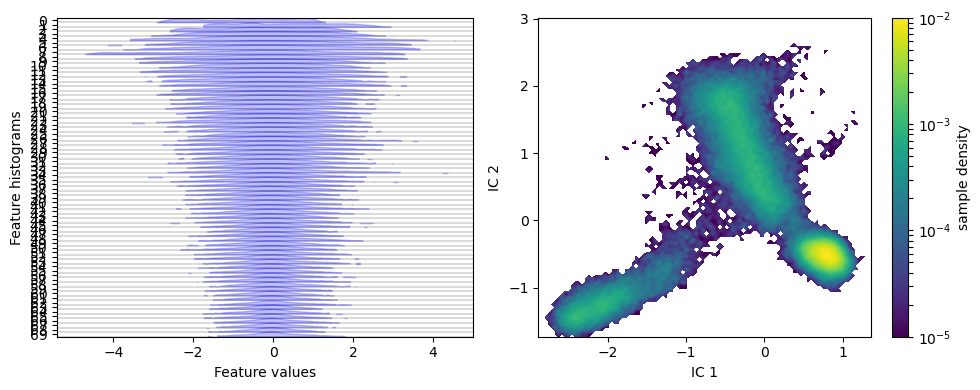

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
#     feature_labels=['IC1', 'IC2', 'IC3'],
    ylog=True, ignore_dim_warning=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('tica_update.png', dpi= 300)

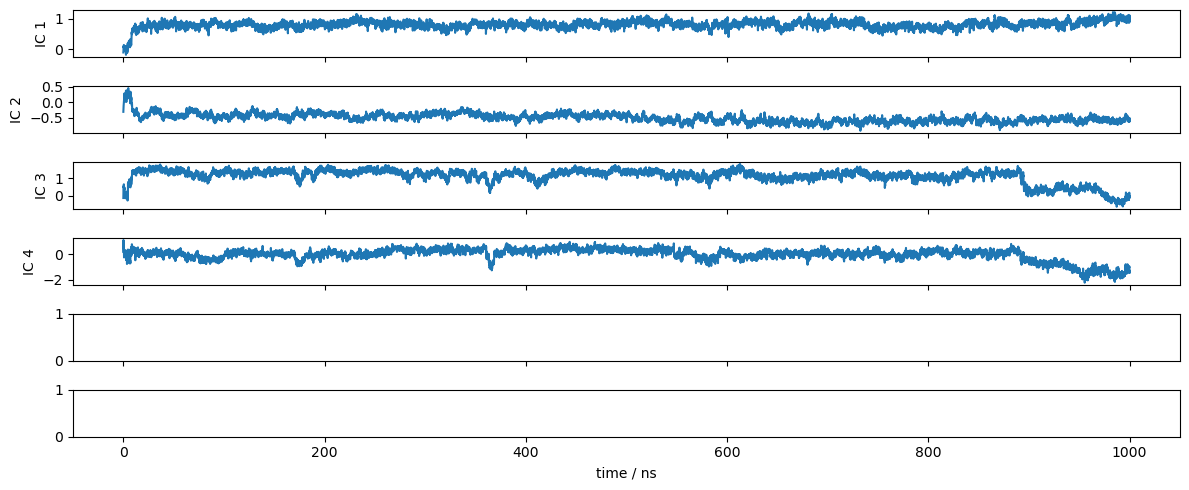

In [12]:
fig, axes = plt.subplots(6, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_out[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_out[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()
# plt.savefig('ics_update.png')

In [74]:
cluster = pyemma.coordinates.cluster_kmeans(
    tica_out, k=100, max_iter=200, stride=1, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


initialize kmeans++ centers:   0%|                      | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                | 0/200 [00:00<?, ?it/s]

getting output of KmeansClustering:   0%|                 | 0/9 [00:00<?, ?it/s]

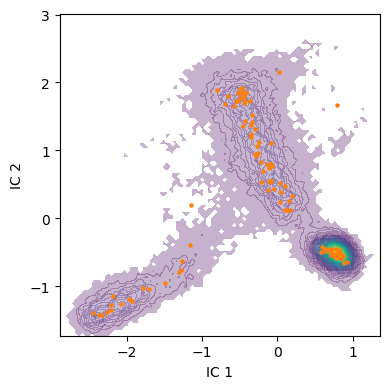

In [75]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()
# plt.savefig('cluster_update.png',dpi=300)

estimating BayesianMSM:   0%|                            | 0/17 [00:00<?, ?it/s]

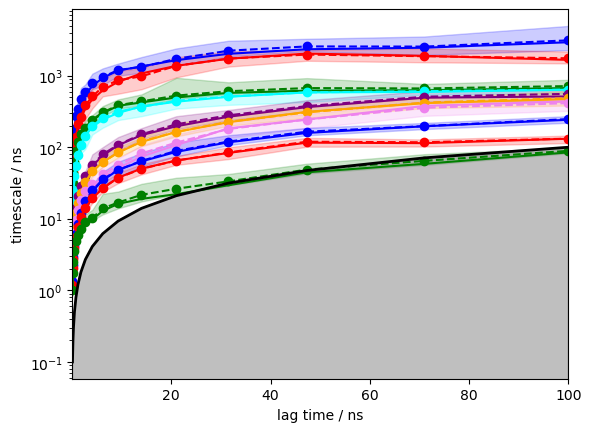

In [76]:
its = pyemma.msm.its(cluster.dtrajs, lags=1000, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);
# plt.savefig('its_update.png',dpi=300)

In [77]:
msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=350, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))

pyemma.msm.estimators.bayesian_msm.BayesianMSM[102]: compute stat. inefficiencie

pyemma.msm.estimators.bayesian_msm.BayesianMSM[102]: Sampling MSMs:   0%| | 0/10

fraction of states used = 1.00
fraction of counts used = 1.00


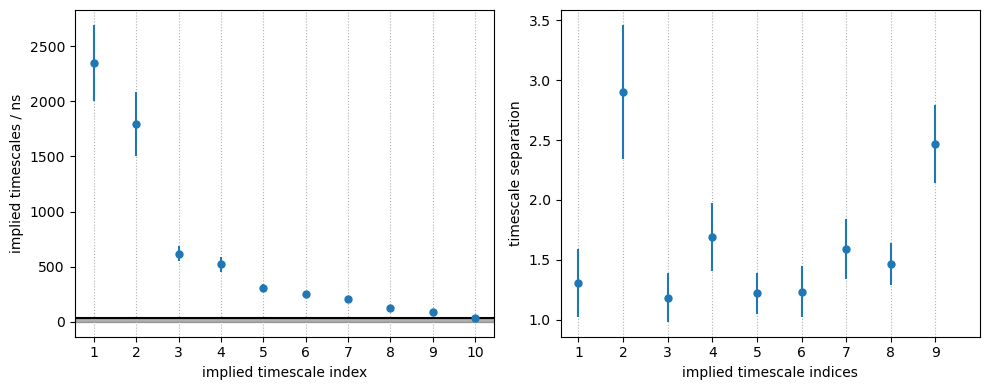

In [78]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 10

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
# axes[1].set_xticklabels(
#     ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
#     rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()
# plt.savefig('spectral_update.png',dpi=300)

estimating BayesianMSM:   0%|                             | 0/9 [00:00<?, ?it/s]

/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 99 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)
/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/msmtools/analysis/api.py:367: UserWarning: truncated eigendecomposition to contain 98 components
  warnings.warn('truncated eigendecomposition to contain %s components' % new_k, category=UserWarning)


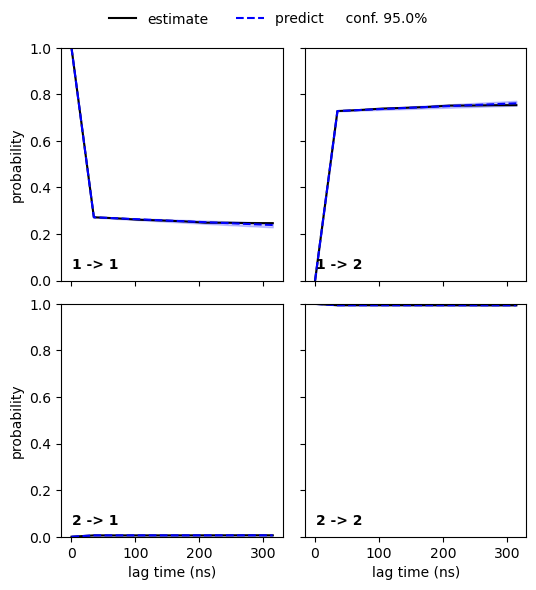

In [86]:
nstates = 2
cktest = msm.cktest(nstates)
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns');
# plt.savefig('cktets.png',dpi = 300)

In [83]:
mfpt = np.zeros((nstates, nstates))
for i in range(nstates):
    for j in range(nstates):
        mfpt[i, j] = msm.mfpt(
            msm.metastable_sets[i],
            msm.metastable_sets[j])

from pandas import DataFrame
print('MFPT / steps:')
DataFrame(np.round(mfpt, decimals=2), index=range(1, nstates + 1), columns=range(1, nstates + 1))


MFPT / steps:


,1,2,3,4
1,0.00,1484.24,23100.60,2999.90
2,633170.37,0.00,21661.74,1368.39
3,768585.81,101803.23,0.00,1813.49
4,772988.30,107854.05,25270.58,0.00


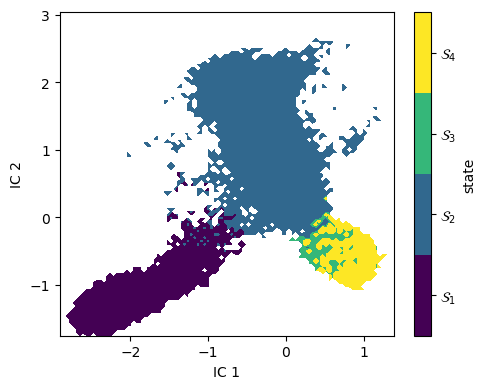

In [84]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
# fig.savefig('pcca_update.png',dpi=400)

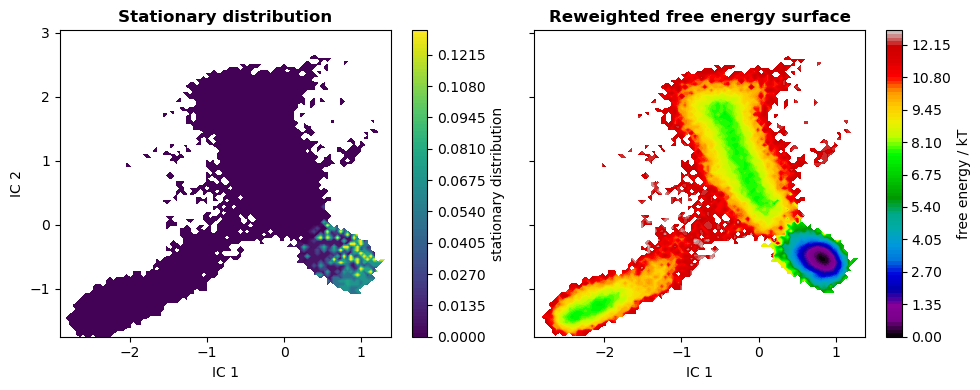

In [85]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()
# plt.savefig('macro_energy_update.png',dpi=400)

In [13]:
# Extract the eigenvectors
eigenvectors = tica_dev.eigenvectors

# Normalize the eigenvectors
eigenvectors_normalized = eigenvectors / np.sum(np.abs(eigenvectors), axis=0)

In [14]:
np.shape(eigenvectors)

(203, 203)

In [24]:
# Choose which tIC to examine, 0 corresponds to the slowest
tIC_index = 0

# Get the weights for this tIC
weights = eigenvectors_normalized[:, tIC_index]

# If you have names for your 14 features you could pair them up with the weights for easier interpretation
feature_names = [f"(resid {i}) and (not backbone)" for i in range(0,203)]   # replace with your list of feature names

# Make a dictionary of feature names and weights
feature_weights = dict(zip(feature_names, weights))

# Sort dictionary by absolute weight
feature_weights_sorted = sorted(feature_weights.items(), key=lambda item: abs(item[1]), reverse=True)

# Print the features and their weights, in descending order of weight
for feature, weight in feature_weights_sorted:
    print(f"{feature}: {weight}")


(resid 114) and (not backbone): 0.04183631520325452
(resid 120) and (not backbone): 0.0376555167364573
(resid 116) and (not backbone): -0.03712452891025489
(resid 183) and (not backbone): 0.0285767453504847
(resid 85) and (not backbone): -0.021051728898346264
(resid 88) and (not backbone): -0.019288654881948388
(resid 184) and (not backbone): -0.018480524550252127
(resid 87) and (not backbone): 0.018426657435960503
(resid 86) and (not backbone): 0.017972865387049564
(resid 60) and (not backbone): -0.01758853678820055
(resid 106) and (not backbone): -0.017333909529676925
(resid 90) and (not backbone): 0.016815981707376772
(resid 122) and (not backbone): -0.01603673420039094
(resid 133) and (not backbone): -0.015334509075247119
(resid 126) and (not backbone): 0.014823346338900844
(resid 75) and (not backbone): 0.014460009810590799
(resid 121) and (not backbone): 0.012746659560691894
(resid 135) and (not backbone): -0.012714432296224883
(resid 80) and (not backbone): 0.012714037865249647


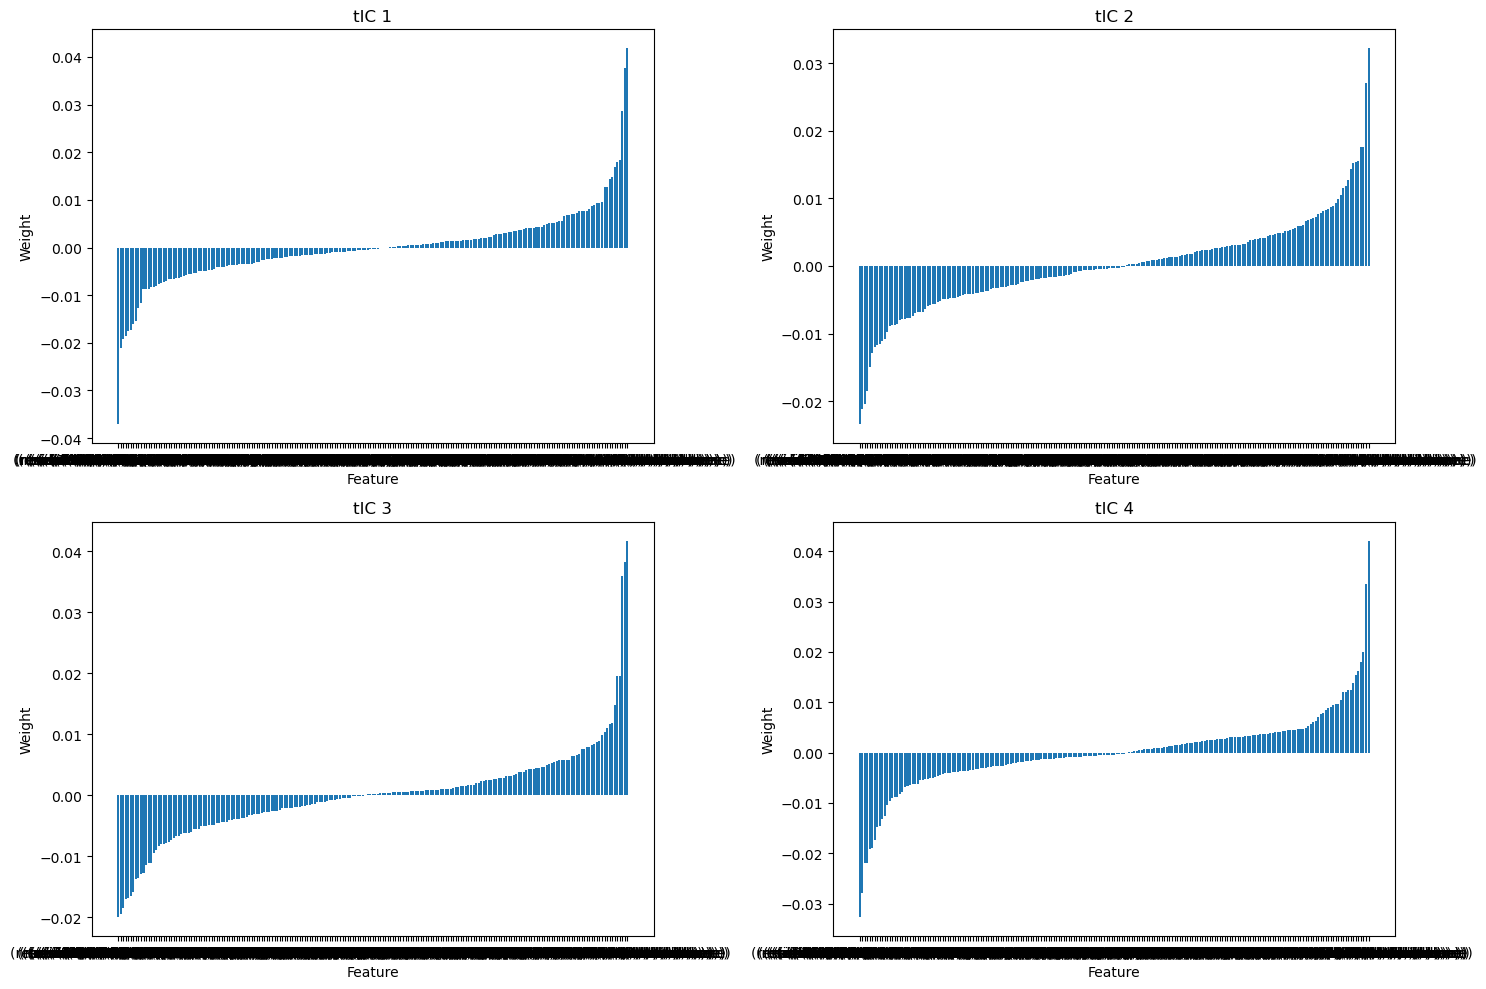

In [27]:
import matplotlib.pyplot as plt

# Extract the weights for the first four tICs
weights_tICs = eigenvectors_normalized[:, :4]

# Generate four subplots, one for each tIC
fig, axs = plt.subplots(2, 2, figsize=(15,10))

# Reshape axs to be one-dimensional
axs = axs.flatten()

# Loop over each tIC
for i in range(4):
    # Sort features by absolute weight for the i-th tIC
    sorted_features = [x for _, x in sorted(zip(np.abs(weights_tICs[:, i]), feature_names))]
    sorted_weights = sorted(weights_tICs[:, i])
    
    # Plot the weights of each feature
    axs[i].bar(sorted_features, sorted_weights)
    
    # Set the title
    axs[i].set_title(f'tIC {i+1}')
    
    # Set the x-axis label
    axs[i].set_xlabel('Feature')
    
    # Set the y-axis label
    axs[i].set_ylabel('Weight')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plot
plt.show()


/tmp/ipykernel_2817559/2783846105.py:2: RuntimeWarning: invalid value encountered in log
  implied_timescales = -20 / np.log(eigenvalues)


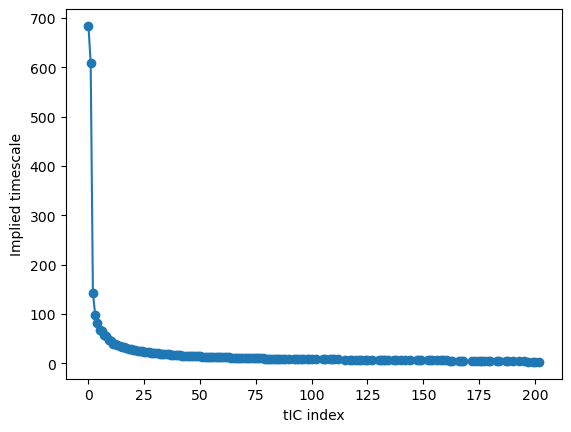

In [28]:
eigenvalues = tica_dev.eigenvalues
implied_timescales = -20 / np.log(eigenvalues)
# Plot the implied timescales
plt.plot(implied_timescales, 'o-')
plt.xlabel('tIC index')
plt.ylabel('Implied timescale')
plt.show()


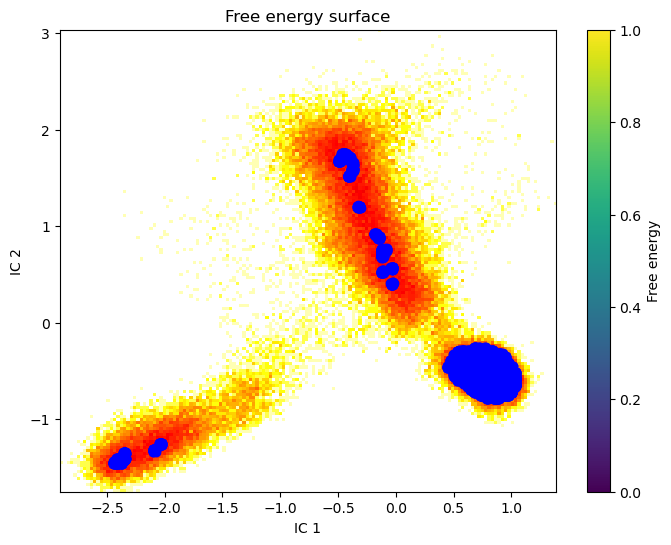

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming tica_concatenated is your tICA result, and you're taking the first two dimensions
x = tica_concatenated[:, 0]
y = tica_concatenated[:, 1]

# Compute 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=150, density=True)
hist = hist.T
# Convert histogram to free energy
free_energy = -np.log(hist + 1e-10)

# Identify points below a certain free energy level
threshold = 0.7  # define a threshold of free energy

# Create a new figure
plt.figure(figsize=(8, 6))

# Plot free energy surface with the 'viridis' colormap
plt.imshow(free_energy, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='hot',vmax=5)

# Identify the bins that correspond to a free energy below the threshold
dense_bins = free_energy < threshold

# Get the indices of the x and y coordinates that fall into the dense bins
x_indices = np.digitize(x, xedges[:-1]) - 1  # we subtract 1 because numpy's digitize function uses 1-based indexing
y_indices = np.digitize(y, yedges[:-1]) - 1

# Get the indices of the frames that are within the dense bins
dense_frame_indices = dense_bins[y_indices, x_indices]

# Plot these points
plt.scatter(x[dense_frame_indices], y[dense_frame_indices], color='b')

# Add colorbar
plt.colorbar(label='Free energy')

plt.xlabel('IC 1')
plt.ylabel('IC 2')

plt.title('Free energy surface')

plt.show()


/uufs/chpc.utah.edu/common/home/u1266568/software/pkg/miniconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_2817559/3864505953.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


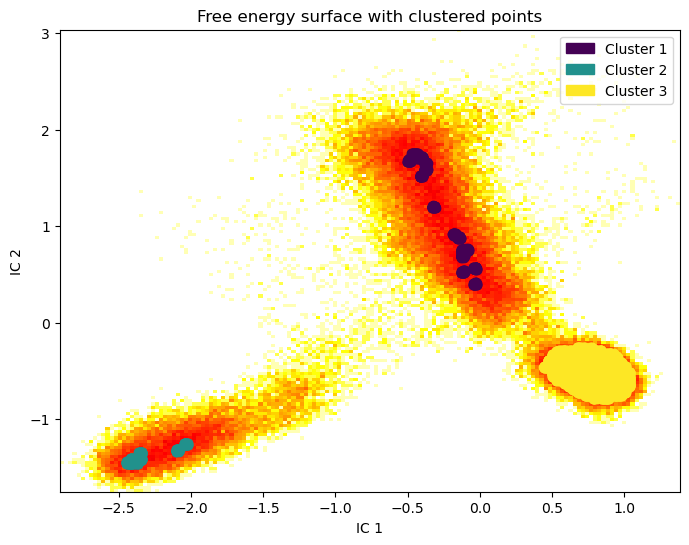

In [36]:
from sklearn.cluster import KMeans
import matplotlib.patches as mpatches

# Create an array of the dense points
dense_points = np.array([x[dense_frame_indices], y[dense_frame_indices]]).T

# Define the number of clusters
n_clusters = 3

# Perform k-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dense_points)

# Get the cluster labels for each point
labels = kmeans.labels_

# Create a color map
cmap = plt.cm.get_cmap('viridis', n_clusters)

# Create a new figure
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the free energy surface
ax.imshow(free_energy, origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto', cmap='hot', vmax=5)

# Create list for legend handles
legend_handles = []

# Loop over each cluster and plot
for i in range(n_clusters):
    cluster_points = dense_points[labels == i]
    scatter = ax.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[cmap(i)], label=f'Cluster {i+1}')
    legend_handles.append(mpatches.Patch(color=cmap(i), label=f'Cluster {i+1}'))

ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
ax.set_title('Free energy surface with clustered points')

# Add legend using the handles
ax.legend(handles=legend_handles)

plt.show()


In [37]:
tic_means = []
for i in range(n_clusters):
    cluster_indices = np.where(labels == i)[0]
    tic_means.append(np.mean(tica_concatenated[dense_frame_indices][cluster_indices], axis=0))


In [38]:
# Convert to a numpy array for easier manipulation
tic_means = np.array(tic_means)

# Calculate the difference in tIC means between clusters
tic_differences = np.diff(tic_means, axis=0)

# Find the tIC with the largest difference between clusters
max_diff_tic = np.argmax(np.abs(tic_differences), axis=1)

print("tICs with largest differences between clusters:", max_diff_tic)

tICs with largest differences between clusters: [1 0]


In [42]:
from sklearn.metrics import pairwise_distances

# Create an array that only contains the dense frames in tICA space
tica_concatenated_dense = tica_concatenated[dense_frame_indices]

# Get the cluster means for each tIC
cluster_means = np.array([np.mean(tica_concatenated_dense[labels == i], axis=0) for i in range(n_clusters)])

# Compute pairwise differences between clusters
pairwise_diff = pairwise_distances(cluster_means)

# For each pair of clusters, identify the tICs that contribute most to their difference
for i in range(n_clusters):
    for j in range(i+1, n_clusters):
        # Compute absolute difference in means along each tIC
        diff_means = np.abs(cluster_means[i] - cluster_means[j])
        # Identify the tICs that contribute most to the difference
        tICs_largest_diff = np.argsort(diff_means)[::-1]
        print(f"Between clusters {i+1} and {j+1}, the tICs with the largest differences are:")
        print(tICs_largest_diff)


Between clusters 1 and 2, the tICs with the largest differences are:
[ 1  0  6  5  8  2 24  4 13 35  3 39 48 37 41 27 43 44 36 50 33  9 49 19
 51 52 28 14 60 30 57 11 54 46 61 16 42 23 31 55 63 12 17 53 29 45 38 26
 10 40 58 59 21 34 15 47  7 62 22 32 64 25 56 68 69 66 67 18 20 65]
Between clusters 1 and 3, the tICs with the largest differences are:
[ 1  0  6  7  3  5 11 38  9  4 13 48 43 27 14 31 12 29 30 16 25 15 36  2
 20 17 10 52 28 58 35 26 24 53 44 23 49 63 40 21 55 57 41 62 56 45 18 32
 22 69 34 66 19 67 39 46 60 59 64 54 61 33 68  8 65 51 37 50 47 42]
Between clusters 2 and 3, the tICs with the largest differences are:
[ 0  1  6  5  3  8  2  7 24 35 13  4  9 39 37 30 31 50 33 41 19 57 23 10
 15 51 44 25 46 40 48 11 38 36 27 60 42 49 20 54 62 61 43 22 18 12 52 28
 29 47 66 64 56 59 58 68 16 32 55 69 45 17 67 26 21 63 14 65 34 53]


In [43]:
features_cont = np.concatenate(arr4) 

In [44]:
import numpy as np

# Assume `features` is a 2D array, with each row representing a frame and each column a feature
# tica_concatenated is your tICA results

# Transpose `features` and `tica_concatenated` so that each row is a feature/tIC and each column is a frame
features_transposed = np.transpose(features_cont)
tica_transposed = np.transpose(tica_concatenated)

# Compute correlation between features and tICs
correlations = np.corrcoef(features_transposed, tica_transposed)

# `correlations` is now a 2D array where the element at (i, j) is the correlation between feature i and tIC j

# Now, we will split the correlation matrix into feature-feature, feature-tIC, tIC-feature, and tIC-tIC
n_features = features_cont.shape[1]
n_tics = tica_concatenated.shape[1]

# The correlation between features and tICs is in the upper right quadrant of the correlation matrix
feature_tIC_correlations = correlations[:n_features, n_features:]


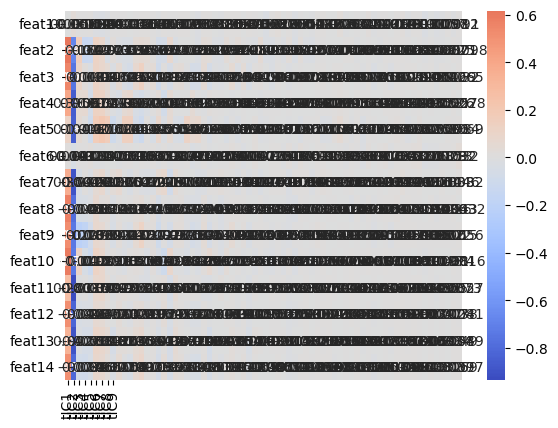

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Using the feature_tIC_correlations array computed in the previous code block

# Create a heatmap
sns.heatmap(feature_tIC_correlations, cmap='coolwarm', center=0, annot=True)

# You can add feature and tIC labels if you have them
feature_names = ['feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'feat7', 'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'feat13', 'feat14']
tIC_names = ['tIC1', 'tIC2', 'tIC3', 'tIC4', 'tIC5', 'tIC6', 'tIC7', 'tIC8', 'tIC9']

# Set the labels
plt.yticks(np.arange(len(feature_names))+0.5, feature_names, rotation=0)
plt.xticks(np.arange(len(tIC_names))+0.5, tIC_names, rotation=90)

plt.show()


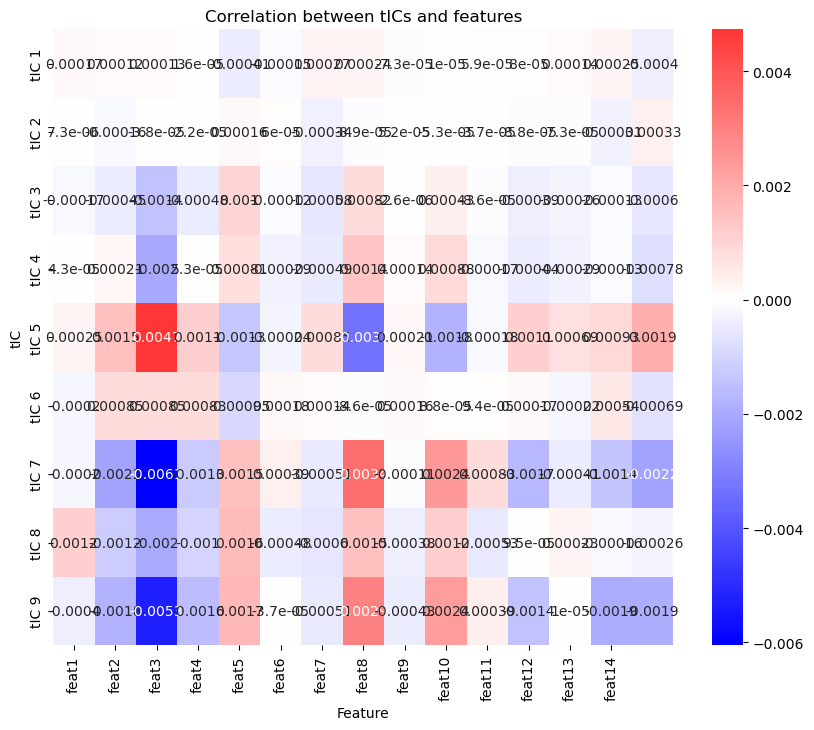

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation between tICs and features
correlation = np.corrcoef(tica_concatenated.T, features_cont.T)

# Select the correlations between tICs and the first 15 features
tic_feature_corr = correlation[:9, 9:24]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(tic_feature_corr, cmap='bwr', center=0, annot=True, 
            xticklabels=feature_names[:15], yticklabels=['tIC '+str(i+1) for i in range(9)])

plt.title('Correlation between tICs and features')
plt.xlabel('Feature')
plt.ylabel('tIC')

plt.show()


In [53]:
# Calculate the highest absolute correlation of each feature with any tIC
highest_correlation_per_feature = np.max(np.abs(tic_feature_corr), axis=0)

# Get the indices of the features with the top 15 highest correlations
top_feature_indices = np.argsort(highest_correlation_per_feature)[-15:]

print("Indices of top 15 features: ", top_feature_indices)


Indices of top 15 features:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


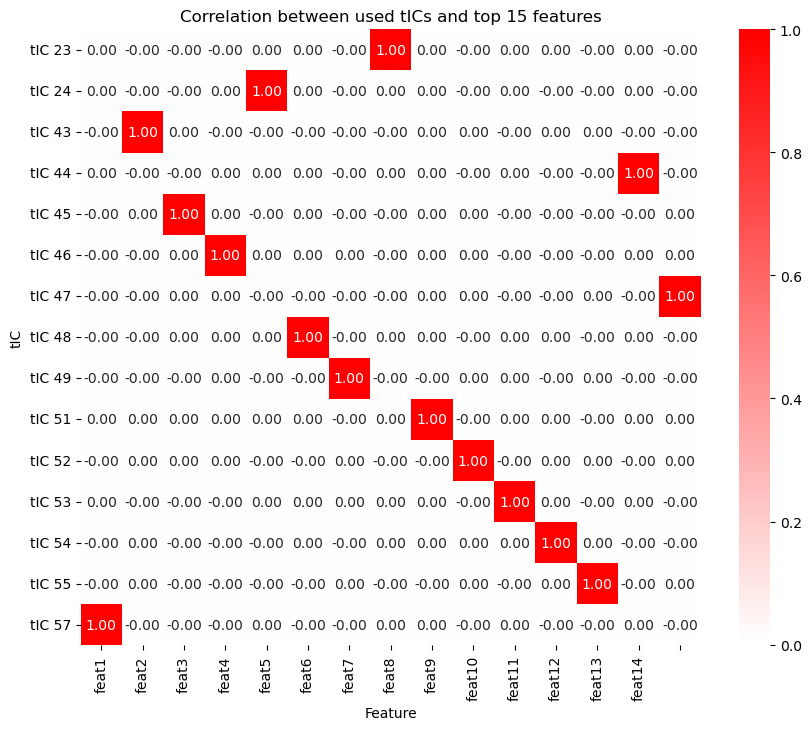

In [54]:
# Select the correlation values of the top 15 features and the used tICs
top_correlations = tic_feature_corr[np.ix_(used_tics_indices, top_feature_indices)]

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(top_correlations, cmap='bwr', center=0, 
            xticklabels=np.array(feature_names)[top_feature_indices], 
            yticklabels=['tIC '+str(i+1) for i in used_tics_indices],
            annot=True, fmt=".2f")
plt.title('Correlation between used tICs and top 15 features')
plt.xlabel('Feature')
plt.ylabel('tIC')
plt.show()


In [56]:
print(top_feature_indices)
print(used_tics_indices)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[22 23 42 43 44 45 46 47 48 50 51 52 53 54 56]
